## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, I will employ several supervised algorithms of my choice to accurately model individuals' income using data collected from the 1994 U.S. Census. i will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. My goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). 

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))



,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, I will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:**  need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# Total number of records
n_records = len(data.index)
print n_records

# Number of records where individual's income is more than $50,000
n_greater_50k = 0
for n in range(n_records):
    if data['income'][n] == '>50K':
        n_greater_50k = n_greater_50k + 1


# Number of records where individual's income is at most $50,000
n_at_most_50k = 0
for n in range(n_records):
    if data['income'][n] == '<=50K':
        n_at_most_50k = n_at_most_50k + 1

# Percentage of individuals whose income is more than $50,000
greater_percent = float(n_greater_50k) * 100 / float(n_records)

# the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

45222
Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 


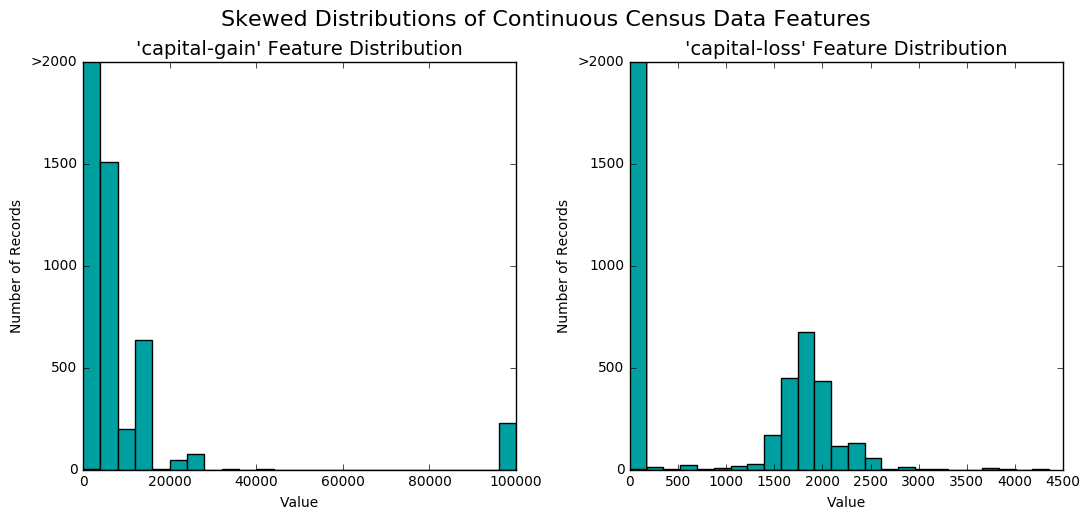

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.


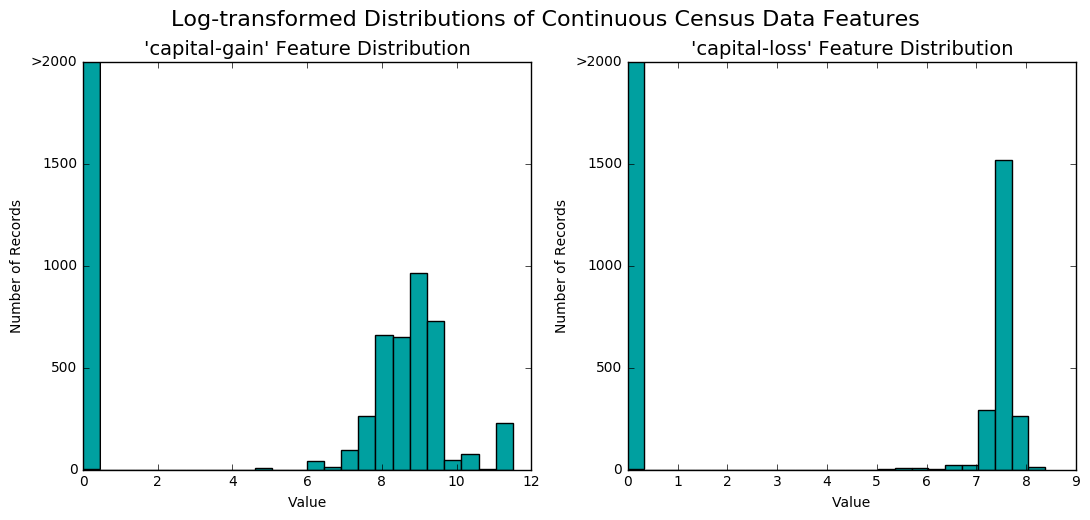

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

I will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
#One-hot encode the 'features_raw' data using pandas.get_dummies()
import pandas
features = pandas.get_dummies(features_raw)

# Encode the 'income_raw' data to numerical values
income = pandas.get_dummies(data["income"])
income = income_raw.apply(lambda x: 1 if x == '>50K' else 0)
# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded


103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [15]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])

print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *UdacityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would is appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *UdacityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *UdacityML* would identify no one as donors. 

###  Naive Predictor Performace

In [8]:
# Calculate accuracy
accuracy = float(n_greater_50k) /float( n_records)

# Calculate F-score using the formula above for beta = 0.5
recall = float(n_greater_50k) / float(n_greater_50k)
precision = float(n_greater_50k) / float(n_records)
fscore = (1 + 0.5**2.0) * precision * recall /((0.5**2.0 * precision) + recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supverised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

###  Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*


         
**Support Vector Machines(kernel_base)**
SVM can be used in Face recognition area.
1. Strengths:1> SVM can handle non-linear surface.  2> Tradeoff between classifier complexity and error can be       controlled explicitly.
2. Weakness: 1> SVM require long training time as there is large datasets thich we used for face recognition and     they are high dimensional.*
3. The data of face recognition is 2 dimensions or 3 dimensions. SVM can deal high dimensions and non-linear data

http://www.ijritcc.org/download/1416544303.pdf

https://www.cs.rutgers.edu/~mlittman/courses/ml04/svm.pdf
            
**Gaussian Naive bayes**
Gaussian Naive bayes can be used for Span filtering.
1. Strengths:1> very fast, low storage  requirements.
2. Weakness:  This method apply Bayes' theorem with strong (naive) independence assumptions between the features.   The model cann't deal combination of spam features.
3. the data of spam is text. Gaussian Naive bayes is an approach commonly used in text classification

https://web.stanford.edu/class/cs124/lec/naivebayes.pdf

https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering#Disadvantages
          
**Logistic regression can be used for breast cancer analysis**
1. Strenght : 1>logistic regression is simple and computationally inexpensive。 2》 logistic regression is directly modeling P(y | X) and does not make any assumption on the true distribution of the response.
2. Weakness： 1>requires large sample size to achieve stable results.
3. Logistic regression is classification.  It 's suitable this analysis.

http://www.arpapress.com/Volumes/Vol10Issue1/IJRRAS_10_1_02.pdf

http://www.sciencedirect.com/science/article/pii/S2001037014000464

http://techemergence.com/machine-learning-industry-predictions/

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
#  Import two metrics from sklearn - fbeta_score and accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    results = {}

    #  Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    #  Calculate the training time
    results['train_time'] = end - start
    #  print results['train_time'], end, start
        
    # Get the predictions on the test set,
    #  then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    from sklearn.metrics import accuracy_score
    
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    #  Compute F-score on the the first 300 training samples
    from sklearn.metrics import fbeta_score
    results['f_train'] = fbeta_score( y_train[:300],predictions_train,  beta = 0.5)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test, beta = 0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, I implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.\
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.



SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


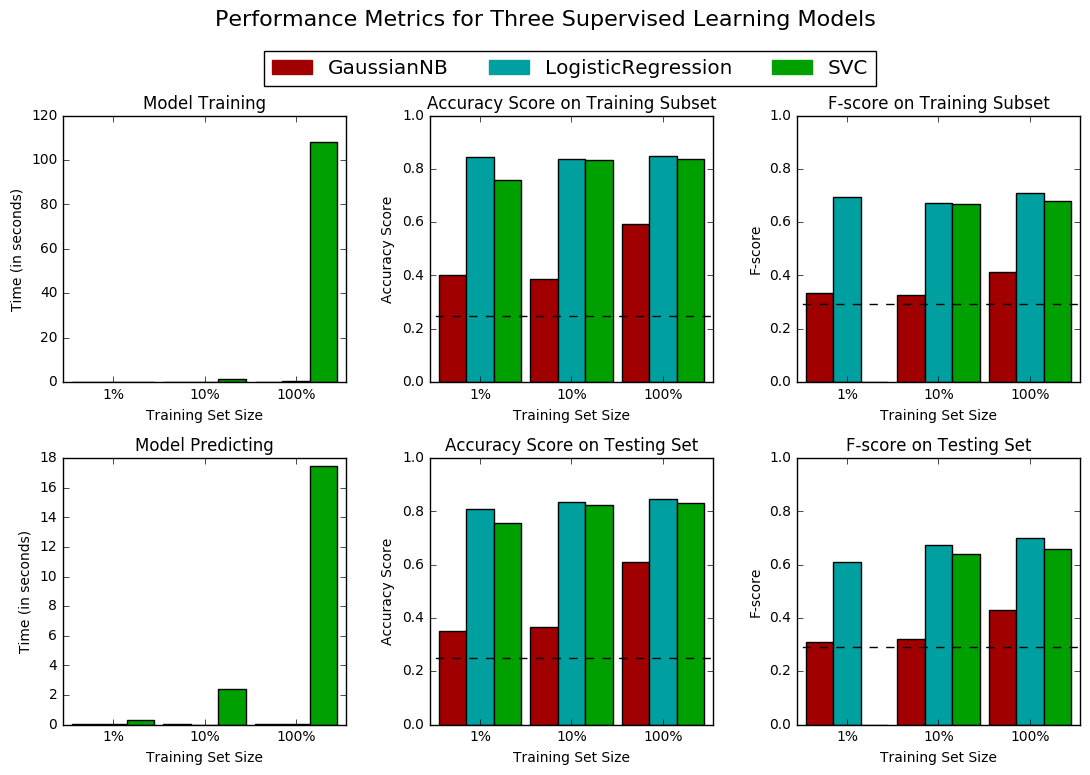

In [11]:
# Import the three supervised learning models from sklearn
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
total_X_train = X_train.shape[0] 

# Initialize the three models
clf_A = svm.SVC(random_state  = 42)
clf_B = GaussianNB()
clf_C = linear_model.LogisticRegression(random_state  = 42)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = total_X_train / 100
samples_10 = 10 * total_X_train / 100
samples_100 = total_X_train 


# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, I choose from the three supervised learning models the *best* model to use on the student data. I perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

###  Choosing the Best Model
 


**Logistic regression is the best algorithm, there are reasons below.**

1> this issue is classification。Generally, GaussianNB solve text classification problem. It 's not suitable for the dataset this issue. Accuracy score of GaussianNB is absolutly smaller than other two. 

2>  In time diagram, SVM's training time is 100 times of Logistic regression's. SVM's prediction time is 8 times of Logistic regression's.In additional, The two scores (Fscore, accuracy) of SVM is a litte smallar than Logistic regression's.  When the training size is 361, the Fscore of SVM almostly equal zero. 



### Describing the Model in Layman's Terms

Logistic regression measures the relationship between the categorical dependent variable and one or more independent variables by estimating probabilities using a logistic function, which is the cumulative logistic distribution. Coefficient of a feature represent the relationship of this feature and label.  The predicted values of label are probabilities and are therefore restricted to (0,1) through the logistic distribution function. Probability is bigger than 0.5 which represent positive result. 

the steps of training
1> Creat a hypothesis function by training data, which be called H(x). 

2> Creat Cost function, which can calculate the deviation between values of H(x) and y.

3> Creat J function which is mean of Cost function of total training point.

4> Model would get a hypothesis function which let J function get minimum value.

5> Get probability of a test case by final hypothesis function, if the probability is bigger than 0.5, the output of label will be 1, therewise, it's 0.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. I need to use the entire training set for this. In the code cell below, I need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier I've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state I set before.
- Create a dictionary of parameters which wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [13]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
#from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import GridSearchCV

# Initialize the classifier
clf =linear_model.LogisticRegression( random_state = 0)

# Create the parameters list you wish to tune
parameters = {'C':[1,5,10,20,40,80,100]}

# Make an fbeta_score scoring object
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
scorer = make_scorer(fbeta_score, beta = 0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

from sklearn.metrics import accuracy_score
# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8483
F-score on testing data: 0.6993

Optimized Model
------
Final accuracy score on the testing data: 0.8494
Final F-score on the testing data: 0.7008


###  Final Model Evaluation


#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |         0.2478            |    0.8483         |    0.8494        |
| F-score        |       0.2917             |    0.6993         |   0.7008       |


1> Accuracy score and F-score of optimized model is a little better than unoptimized model's.

2> The performance of optimized model is better than benchmark predictor. the Accuracy score and F-score of optimized model obviously bigger than benchmark predictor's.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, there are five features I believe to be most important for prediction.

There are hours-per-week, occupation, capital-gain, capital-loss ,education_level, which I believe to be most important for prediction. 

From more important to less important, I order it below:

**hours-per-week > occupation > capital-gain = capital-loss > education_level**

1> As "non-exempt" employee，income of working is calculated by wages(a pay rate per hour) multiplied by the number of hours worked. More hours mean more income. So hours-per-week become most important feature.

2> Different occupation has different wage. For example, A engineer get more income than a casher. 

3> Investment is a important way of getting gain or loss.

4> Many position's wage depend on the level of education.


### Implementation - Extracting Feature Importance
Choose DecisionTreeClassifier that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

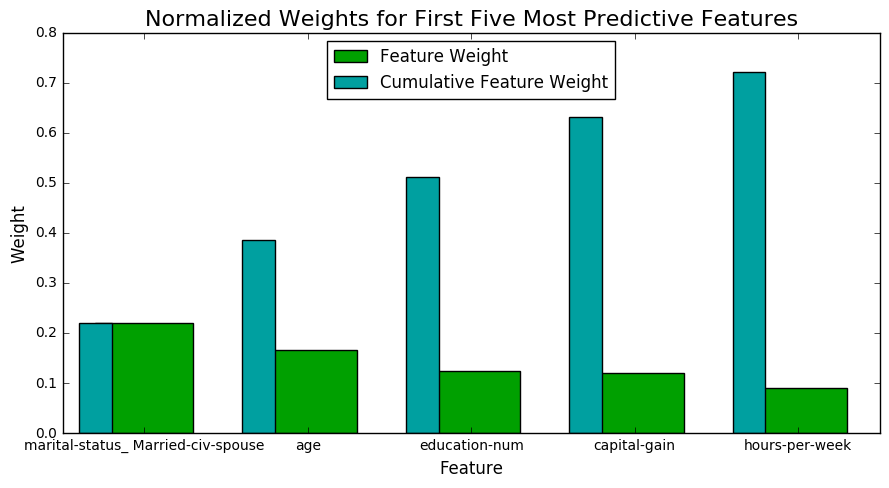

In [12]:
# TImport a supervised learning model that has 'feature_importances_'
from sklearn.tree import DecisionTreeClassifier
# Train the supervised model on the training set 
model = DecisionTreeClassifier(random_state  = 42).fit(X_train, y_train)

# Extract the feature importances
importances = model.feature_importances_


# Plot
vs.feature_plot(importances, X_train, y_train)

###  Extracting Feature Importance

Three features are different with my answer.

1> I am surprised that the most important feature is marital_status_married-civ-spouce, but I accept this result. A person who has spouce indicate a sense of responsibility. It make he/she work hard.

2> Age should be a important feature. I missed it in question 6. A person can get more experience as age incresing. Experience is a important factor of salary.

3> education-num is comtinuous data. I am not sure the definition of it. 


### Feature Selection

In [24]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8492
F-score on testing data: 0.7010

Final Model trained on reduced data
------
Accuracy on testing data: 0.8352
F-score on testing data: 0.6693


###  Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

1> F-score and accuracy score of the model using only five features is lower than the model using all features. The features are insufficient which lead to bring irreducible error.

2> if training time was a factor, using the reduced or original data depend on the different classification. For example, if the project choice SVM classification, using reduced data should be necessary. If project choice naive bayes classification, I could using reduced data, because this classification is simple. The cost of time is cheap.

